# Assignment 2: The Winter is here
##### This works best with epic battle music. No spoilers present.
<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Tywin Lannister was right when he said: "The great war is between death and life, ice and fire. If we loose, the night will never end"<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;It has been six months since the white walkers' army marched into the north, led by the night king himself on a dead dragon. It has been a battle like never before: never before have men faced such an enemy in battle, never before have men fought so bravely against a united threat, and never before have they been so gravely defeated.<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; While Cersei is in King's landing, brave men have died fighting the great war. Among others, Tyrion is dead, Arya is dead and Jon Snow is dead, again. In a desperate battle, Daenerys leads all her forces in a final stand-off with the dead just south of Winterfell. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Her army defeated, she is now on the run on her dragon in an air battle, being chased by two of her own dragons, the Night king and a dead Jon Snow. Suddenly, the Night king's spear hits Danny's dragon, who, raining blood and fire, falls into ice, taking the lost queen, with him. <br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Daenerys opens her eyes in a strange place, a place which does not follow the rules of space and time, where the dead souls killed by the dead men are trapped, forever. But who woke her up? There stands near her, Tyrion, with Jorah, Davos, Jon Snow, and everybody else. They all indulge in a heartfelt reunion when someone yells- "But how do we get out?<br />
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Varys sees a talking crystal close by, who asks them of completing a task, which on completion would allow them to go back to the land of the living, with the ultimate tool to defeat the white-walkers and kills the night king, the Dragon-axe. They have summoned you for help, as the task is out of their expertise, to apply a modified CNN to solve the object detection problem on the PASCAL VOC dataset. Varys, the master of whisperers, has used his talents to import the following for you:

In [1]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()
# You can ask Varys to get you more if you desire
import xml.etree.ElementTree as ET
import glob
import PIL.Image
import PIL.ImageChops
import torch.nn as nn
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import skimage.measure
import skimage.morphology
from random import randint

resnet_input = 224#size of resnet18 input images

In [2]:
# Cersei chose violence, you choose your hyper-parameters wisely using validation data!
batch_size = 100
num_epochs = 5
learning_rate =  0.01
hyp_momentum = 0.9

## Build the data
The hound who was in charge for getting the data, brought you the following links:
<br/>Training and validation:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
<br/>Testing data:
<br/>http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
<br/>He also told you that the dataset(datascrolls :P) consists of images from of 20 classes, with detection annotations included. The JPEGImages folder houses the images, and the Annotations folder has the object-wise labels for the objects in one xml file per image. You have to extract the object information, ie. the [xmin, ymin] (the top left x,y co-ordinates) and the [xmax, ymax] (the bottom right x,y co-ordinates) of only the objects belonging to the given 20 classes(aeroplane, bicycle, boat, bottle, bus, car, cat, chair, cow, dining table, dog, horse, motorbike, person, potted plant, sheep, train, TV). For parsing the xml file, you can ask Varys to import xml.etree.ElementTree for you. <br/>
<br/> You can then ask Bronn and Jamie to organize the data as follows:
<br/> For every image in the dataset, extract/crop the object patch from the image one by one using their respective co-ordinates:[xmin, ymin, xmax, ymax], resize the image to resnet_input, and store it with its class label information. Do the same for training/validation and test datasets. <br/>
##### Important
You also have to collect data for an extra background class which stands for the class of an object which is not a part of any of the 20 classes. For this, you can crop and resize any random patches from an image. A good idea is to extract patches that have low "intersection over union" with any object present in the image frame from the 20 Pascal VOC classes. The number of background images should be roughly around those of other class objects' images. Hence the total classes turn out to be 21. This is important for applying the sliding window method later.

In [3]:
classes = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')


In [4]:
# Taken form pyimagesearch for calculating intersection over union
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
 
    # compute the area of intersection rectangle
    interArea = (xB - xA + 1) * (yB - yA + 1)
 
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
 
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea + np.finfo(float).eps)
 
    # return the intersection over union value
    return iou

In [5]:
# Taken from stackoverflow for drawing random bounding boxes
def random_bbox(bbox):
    v = [randint(0, v) for v in bbox]
    left = min(v[0], v[2])
    upper = min(v[1], v[3])
    right = max(v[0], v[2])
    lower = max(v[1], v[3])
    return [left, upper, right, lower]

In [6]:
def jamie_bronn_build_dataset(dir,img_path,train):            
    image = PIL.Image.open(img_path)
    img_name = img_path.split("/")[-1].split(".")[-2]
    print(img_name)
    xml_path = dir+'/Annotations/'+img_name+'.xml'
    xml_tree = ET.parse(xml_path)
    xml_root = xml_tree.getroot()

    temp_img = PIL.Image.new('RGB',image.size,0)
#     image.show()
    
    location = []
    labels = []
    object_img = []
    img_whole = []
    for object in xml_root.findall('object'):
        name = object.find('name').text
        position = [int(object.find('bndbox').find('xmin').text), int(object.find('bndbox').find('ymin').text),
                    int(object.find('bndbox').find('xmax').text), int(object.find('bndbox').find('ymax').text)]
        location.append(position)
        crop_img = image.crop(position).convert('RGB')
        object_img.append(crop_img)
        labels.append(classes.index(name))
        if not train:
            img_whole.append(image)
        
#         temp_img.paste(crop_img,position)

#     temp_img = PIL.ImageChops.subtract(image,temp_img)
#     l = skimage.morphology.label(np.array(image.convert('L')))
#     regions = skimage.measure.regionprops(l)
#     max_area = 0
#     for region in regions:
#         if region.area >= max_area:
#             position = region.bbox
#             max_area = region.area
            
#     location.append(position)        
#     crop_img = image.crop(position).convert('RGB')
# #     crop_img.show()
#     object_img.append(crop_img)
#     labels.append(classes.index('__background__'))

    iou_threshold = 0.3
    num = 0
    while(num < 1):
        bbox = image.getbbox()
        boxA = random_bbox(bbox)
        mscore = 0
        for boxB in location:
                score = (bb_intersection_over_union(boxA, boxB))
                if (score > mscore):
                    mscore = score
        if (mscore < iou_threshold):
            object_img.append(image.crop(boxA).convert('RGB'))
            labels.append(classes.index('__background__'))
            if not train:
                img_whole.append(image)
            num = num + 1
        
    return object_img, labels, img_whole

In [24]:
class hound_dataset(torch.utils.data.Dataset): # Extend PyTorch's Dataset class
    def __init__(self, root_dir, train, transform=None):
        # Begin
        print(train)
        if(train):
            dir = root_dir + '/train/VOCdevkit/VOC2007'
        else :
            dir = root_dir + '/test/VOCdevkit/VOC2007'
        self.transform = transform
        self.train = train
        self.img = [];
        self.label = [];
        self.img_whole = []
        i = 0
        for img_path in glob.glob(dir+'/JPEGImages/*.jpg'):
            object_img, name, image = jamie_bronn_build_dataset(dir,img_path,train)
            self.img.extend(object_img)
            self.label.extend(name)
            self.img_whole.extend(image)
#             i = i+1
#             if i == 7:
#                 break
                       
                
    def __len__(self):
        return len(self.img)
        
    def __getitem__(self, idx):
        if self.transform is None:
            if not self.train:
                return (transforms.ToTensor(self.img[idx]),self.label[idx],transforms.ToTensor(self.img_whole[idx]))
            else:
                return (transforms.ToTensor(self.img[idx]),self.label[idx],transforms.ToTensor(-1))
        else:
            img_transformed = self.transform(self.img[idx])
            if not self.train:
                return (img_transformed,self.label[idx],transforms.ToTensor(self.img_whole[idx]))
            else:
                return (img_transformed,self.label[idx],transforms.ToTensor(-1))

In [8]:
# train_dataset = hound_dataset(root_dir='.', train=False, transform=None) # Supply proper root_dir

## Train the netwok
<br/>You can ask Arya to train the network on the created dataset. This will yield a classification network on the 21 classes of the VOC dataset. 

In [9]:
composed_transform = transforms.Compose([transforms.Scale((resnet_input,resnet_input)),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor()])
train_dataset = hound_dataset(root_dir='.', train=True, transform=composed_transform) # Supply proper root_dir
test_dataset = hound_dataset(root_dir='.', train=False, transform=composed_transform) # Supply proper root_dir

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

True
007451
000270
008144
006174
008438
005669
007876
002677
001214
001045
005599
008051
002417
001164
007021
002293
001083
006190
007388
008391
006617
006421
009469
001768
007133
000850
006129
004075
007527
006947
006806
004145
004686
009845
007575
006300
005159
008645
000020
000220
008468
009954
006972
007857
006841
001899
008372
003946
009686
003477
002689
003913
001784
002767
007189
006355
004091
001460
009816
003327
007439
003830
001911
003082
009772
006455
003589
009839
002267
007723
007390
009308
005138
009524
000772
008326
006139
000048
005755
009000
009584
006172
008738
004351
008338
005209
003433
006222
002039
005222
007325
003259
000163
007732
007185
009316
003685
002772
001073
001828
004352
001084
006572
002249
005016
000828
001678
002027
006916
009860
007389
003705
006645
005430
000498
000797
006714
002480
007330
008550
000892
009499
000476
006968
006463
006391
009282
008220
008970
001541
006206
003788
007838
004974
005791
006892
008727
005600
005566
002471
008772
000929
0

001036
003954
007729
002308
009424
009480
009195
003890
001397
005940
005840
003708
004992
005176
009197
006611
005487
004013
008723
007149
004215
007065
008485
001230
008374
003874
000619
006848
009148
006847
003525
001515
008926
004735
002659
008049
004105
008341
000146
008873
009655
007883
005648
001176
001191
001892
000021
000857
005992
003593
008576
007224
003137
005824
001739
004273
003691
001225
008442
001071
007578
008936
000041
003865
007314
004982
002741
002938
005664
005307
004828
007624
008564
009886
002935
005579
008023
006117
009738
001209
005244
004625
002030
004117
007408
003509
005519
006520
006781
009904
003847
004649
006814
001402
007078
003763
003885
003285
006769
002670
000782
009117
004868
001341
005378
007585
008909
004527
005483
004009
006301
008983
009789
003496
001684
000531
002376
003429
007130
004255
000153
003105
000099
006747
007363
009438
007372
002848
001977
001780
006773
004439
004514
005988
004519
001289
007230
000171
003773
007868
001685
009884
007039

005789
005998
007511
009005
006678
001729
009123
008989
003320
005889
009042
002593
007664
007187
001200
008698
000823
003272
000500
006417
006648
009719
006900
009456
005843
004468
003185
007204
005805
002738
004067
005631
008209
003760
004517
008115
002691
003430
006337
006702
008384
005061
005874
000052
008953
006338
009180
000122
003642
007919
003556
007872
006219
002439
005614
000661
001061
004946
007432
007735
003450
007856
006444
009224
006400
008633
009617
005220
006708
003956
001806
008410
003879
005018
001212
002022
006842
003834
003118
009239
005351
006627
004553
003961
005318
007841
008064
006578
002571
000582
008843
008306
005370
008975
000266
002090
002763
002533
005421
008529
002757
009193
002683
006917
001821
002088
009214
004626
007097
009881
000443
009326
005246
001365
002490
006352
002967
006803
002425
004508
008690
006028
004220
006488
005349
002208
004303
009834
001436
006038
008044
009099
002182
001107
005863
004204
005850
007059
007682
008430
004928
008453
009269

007611
006295
008793
009580
006538
000810
002259
001334
003748
006772
005134
001982
008346
000565
008695
003510
001732
004518
003684
002696
003465
007092
004298
009500
006250
009327
005297
007089
000117
005951
009259
008533
007809
004689
000770
005395
007984
006912
004170
009100
006850
000720
004990
001556
003255
001766
001797
000424
005268
003491
002064
008381
003260
003072
006270
008923
007697
001750
009443
005654
007667
002867
002870
002496
002986
003258
005389
007035
008880
001439
000477
001603
004907
006348
007751
000878
006989
008692
008871
007411
008628
008856
008794
004205
006565
001765
008636
003899
001842
007779
002099
000189
003690
006009
001204
001170
009049
007007
008773
000577
001887
004326
002953
000142
001862
007727
001464
000246
002441
003045
003181
003949
005507
002816
000036
000588
006635
005679
005952
009306
007071
008710
008670
007279
004481
004701
009068
006449
006251
003735
004239
003806
006593
004095
004178
001136
002664
005657
004878
005756
009448
008978
009944

006074
000645
000528
008211
006209
009215
001708
000787
009597
001113
004588
009362
007172
009094
002868
000936
005121
001001
007688
009698
009460
003791
006279
000187
006499
009255
004152
009841
000320
001129
000633
000347
000282
006668
002919
007590
003814
002155
008225
008858
007191
002273
003379
004265
000520
003895
009543
009676
006084
006230
006396
000180
004623
004903
002281
001493
003973
002021
008284
004958
000318
000845
007810
000834
004230
000680
001673
006697
007503
005454
000218
002190
002896
000806
007234
002697
006664
005624
001277
001148
008979
007422
003028
002605
002348
009174
005644
003162
005730
007482
005223
001936
003417
002782
009685
000209
009020
006450
008822
005799
001759
008125
007762
004825
004973
008836
003511
005885
009687
001444
001778
005441
004722
008037
002377
000625
000830
007946
008316
003108
009150
004960
006150
007108
004753
004270
001240
002268
003083
006296
003004
004325
004540
001152
002572
007926
006276
005348
007653
002369
003039
005315
003100

006244
008786
007384
002486
007339
001153
001047
006024
005750
007851
008896
007665
003841
009436
004824
008675
002274
006142
000783
006049
007440
001956
001183
003884
008981
008745
006114
006056
007860
006168
003610
004260
004410
001302
003221
002904
002857
005978
004167
008460
002018
001621
009376
009803
003981
008887
001987
008474
003512
006511
001656
002381
003782
005744
003825
007945
005767
007895
001891
008065
004079
005162
004443
005087
000561
008656
005504
003995
008798
004337
007941
007641
002131
000258
007047
000792
002708
006207
002535
001819
008686
009590
001370
002771
002725
008774
006629
001096
004311
007378
003901
003030
009366
001551
005323
002026
000942
009310
008681
007817
004641
000890
007842
007583
005570
007726
004262
006169
003479
001026
002928
003934
000238
008028
007262
005147
008007
003264
006882
001846
008192
007450
004658
006274
009730
008278
005913
008906
004536
004629
008371
002085
006505
005939
003332
000181
009916
004851
000375
007827
003652
009301
006239

003295
009267
004161
006975
003607
003734
004112
006579
001381
005096
009069
002105
007562
001123
003878
005341
001367
007081
005772
005691
005986
007582
009927
002596
002614
004667
001646
007589
005942
008924
001757
007975
003302
008143
001969
006390
006757
007737
003232
004621
002057
003375
007333
009207
004094
007366
004680
004763
003125
007501
005099
005734
001308
001088
007304
003463
004050
004213
004408
002380
004344
009135
007759
009047
002506
008800
004147
006412
004183
004445
000449
004505
002743
002851
005932
005495
006589
006854
001606
006406
001300
003831
006942
008290
006788
000638
007382
000801
001150
001291
003245
008787
008785
006804
006144
002351
004482
001335
008781
006620
005966
003676
007893
006138
007116
006744
004049
002147
004909
003741
003771
008603
004700
008922
000745
002008
008844
006513
005665
002007
007364
004198
001354
004026
001407
001986
002150
000006
004996
000773
000527
008237
000014
005401
006574
005927
009031
006608
000976
005575
009589
009262
004478

005967
004716
007209
005787
000195
008170
000575
000226
006879
006754
001448
004899
001835
008395
005635
006090
001321
008446
001668
000571
009102
004456
003357
005763
008497
004538
006650
007034
009462
004594
002440
008155
001988
005192
008348
001030
000819
005444
002408
007301
000179
003800
003226
007321
008754
001666
002314
009843
008646
005366
005832
004920
004731
009474
001866
007131
003192
007463
004465
008934
009648
002031
001319
003761
007973
005977
001802
002863
005449
008367
008305
004533
002650
007906
005041
008613
009915
007362
004299
002177
000137
003225
004454
000493
002964
001245
004845
006340
002009
007927
007406
004957
000361
006242
002573
006487
003914
001917
003558
003989
007917
002203
007725
009396
006871
009888
007430
007407
000909
009914
006717
005661
008027
009864
004486
007286
006477
009538
009167
004803
006489
001935
001111
009601
008994
007151
004101
001716
007929
000437
003716
009931
001031
007982
005083
006217
004268
003799
002983
008333
000201
001552
003747

000533
003563
006790
008679
009736
004109
007444
009383
002053
008881
002790
005347
005133
005425
006672
002739
008018
000284
003277
000983
002149
001658
000568
005987
004378
004547
002731
007581
005562
001773
005965
007179
006888
003384
000708
005907
004234
006372
003851
001974
004144
000212
004078
002629
002787
006758
008198
004199
003358
005040
009604
000718
004603
008651
004506
005308
005464
003167
006568
001520
006191
002144
007254
008641
009547
007026
004252
008894
005848
006143
005683
002222
008696
000183
007792
009263
004733
000413
004072
002733
008674
009715
007648
007175
003902
004755
006228
001665
005243
007716
005339
007870
000392
007061
006843
006590
007415
005857
005240
004032
009929
006059
000074
009846
005053
002591
004056
009302
003434
000646
004473
002447
004330
002631
001243
009777
008869
006561
008834
007719
008353
001373
008897
009026
006954
002409
007442
002707
003139
009739
005354
001804
008882
003040
000642
002856
003459
006399
002386
003816
009248
000963
006895

In [13]:
labels_list = []
for image,label,_ in train_loader:
    labels_list.extend(label)
weights = []
for i in range(len(classes)):
    if labels_list.count(i) == 0 :
        weights.append(labels_list.count(i))
    else:
        weights.append(1/labels_list.count(i))
weights = [x/sum(weights) for x in weights]
print (weights) 

[0.0044754879233965435, 0.06775428998229631, 0.05365232053622028, 0.03744018361292167, 0.05634841704557808, 0.0353732965049528, 0.08245099258875029, 0.013641526754343113, 0.05765210792838066, 0.01566108239115927, 0.06299626400039347, 0.0723440967230325, 0.04168526019356891, 0.055238103409212015, 0.05750428201061558, 0.004117251695270805, 0.03588267197462412, 0.06353164301456113, 0.05276863525680018, 0.0683739938540856, 0.06110809259983672]


### Fine-tuning
Litlefinger has brought you a pre-trained network. Fine-tune the network in the following section:

In [14]:
resnet18 = models.resnet18(pretrained=True)

resnet18.fc = nn.Linear(resnet18.fc.in_features, 21)

# Add code for using CUDA here
use_gpu = False
if(torch.cuda.is_available()):
    use_gpu = True
    resnet18.cuda()

In [15]:
criterion = nn.CrossEntropyLoss(torch.FloatTensor(weights).cuda())
print(torch.FloatTensor(weights).cuda())
# Update if any errors occur
optimizer = torch.optim.SGD(resnet18.parameters(), learning_rate, hyp_momentum)


1.00000e-02 *
  0.4475
  6.7754
  5.3652
  3.7440
  5.6348
  3.5373
  8.2451
  1.3642
  5.7652
  1.5661
  6.2996
  7.2344
  4.1685
  5.5238
  5.7504
  0.4117
  3.5883
  6.3532
  5.2769
  6.8374
  6.1108
[torch.cuda.FloatTensor of size 21 (GPU 0)]



In [16]:
def arya_train():
    # Begin
    loss_arr = []
    for epoch in range(num_epochs):
        for i, (images, labels, _) in enumerate(train_loader):  
            # Convert torch tensor to Variable
            images = Variable(images)
            labels = Variable(labels)
            if(use_gpu):
                images=images.cuda()
                labels=labels.cuda()
            # Forward + Backward + Optimize
            optimizer.zero_grad()  # zero the gradient buffer
            outputs = resnet18(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_arr.append(loss.data[0])
            if (i+1) % batch_size == 0:
                print ('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
                       %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss.data[0]))
    plt.plot( np.array(range(1,len(loss_arr)+1)), np.array(loss_arr))
    plt.show()

Epoch [1/5], Step [100/206], Loss: 0.7089
Epoch [1/5], Step [200/206], Loss: 1.0026
Epoch [2/5], Step [100/206], Loss: 0.3943
Epoch [2/5], Step [200/206], Loss: 0.4784
Epoch [3/5], Step [100/206], Loss: 0.2791
Epoch [3/5], Step [200/206], Loss: 0.3476
Epoch [4/5], Step [100/206], Loss: 0.3317
Epoch [4/5], Step [200/206], Loss: 0.2669
Epoch [5/5], Step [100/206], Loss: 0.0545
Epoch [5/5], Step [200/206], Loss: 0.0605


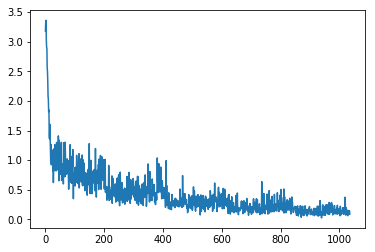

CPU times: user 16min 28s, sys: 2min 22s, total: 18min 50s
Wall time: 16min 10s


In [17]:
%time arya_train()
torch.save(resnet18.state_dict(), 'resnet18.pkl')

In [25]:
resnet18.load_state_dict(torch.load('resnet18.pkl'))
def classification_test(model):
    # Write loops for testing the model on the test set
    # You should also print out the accuracy of the model
    correct = 0
    total = 0
    
    for i,(images, labels, _) in enumerate(test_loader):
        images = Variable(images)
        
        if(use_gpu):
            images = images.cuda()
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.cpu() == labels.cpu()).sum()
    print('Accuracy of the network on the ' + str(total) +' test images: %d %%' % (100 * correct / total))
    
classification_test(resnet18)

TypeError: batch must contain tensors, numbers, dicts or lists; found <class 'PIL.JpegImagePlugin.JpegImageFile'>

# Testing and Accuracy Calculation
Jorah then asks a question, how is this a detection task?<br/>
As everybody wonders, Theon Greyjoy suggests a slding window method to test the above trained trained network on the detection task:<br/>
"We take some windows of varying size and aspect ratios", he mumbled, "and slide it through the test image (considering some stride of pixels) from left to right, and top to bottom, detect the class scores for each of the window, and keep only those which are above a certain threshold value!". "He is right", says Samwell, "I read a similar approach in the paper -Faster RCNN by Ross Girshick in the library, where he uses three diferent scales/sizes and three different aspect ratios, making a total of nine windows per pixel to slide". You need to write the code and use it in testing code to find the predicted boxes and their classes.

In [27]:
def theon_sliding_window(image,aspect_ratio,size,slide_amount):
    # Begin
    windows = []
    labels = []
    threshold = 0
    for x in xrange(0,image.size[0],slide_amount):
        for y in xrange(0,image.size[1],slide_amount):
            box = [x,y,int(x+size*aspect_ratio),y+size]
            crop_img = image.crop(box).convert('RGB')
            crop_img = composed_transform(crop_img)
            images = Variable(crop_img)
            images = images.unsqueeze(0)
            if(use_gpu):
                images = images.cuda()
            output = resnet18(images)
            output = torch.nn.functional.softmax(output)
            prob,label = torch.topk(output.data,1)
#             print (prob[0][0])
#             print (label)
            if prob[0][0] > threshold and label[0][0] != 0:
                windows.append(box)
                labels.append(label)
    return windows,labels

"Wait", says <b>Jon Snow</b>, "The predicted boxes may be too many and we can't deal with all of them. So, I myself will go and apply non_maximum_supression to reduce the number of boxes". You are free to choose the threshold value for non maximum supression, but choose wisely [0,1].

In [28]:
def aegon_targaryen_non_maximum_supression(boxes,labels,threshold = 0.3):
    boxes = np.array(boxes)
    nms_boxes = []
    nms_labels = []
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
#     if boxes.dtype.kind == "i":
#         boxes = boxes.astype("float")

    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
    # grab the last index in the indexes list and add the
    # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        nms_boxes.append(boxes[i])
        nms_labels.append(labels[i])
        
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > threshold)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type
#     return boxes[pick].astype("int") , labels[pick]
    return nms_boxes , nms_labels

In [31]:
image = PIL.Image.open('/home/deepak/CS698O/Assignments/Assignment2/test/VOCdevkit/VOC2007/JPEGImages/000002.jpg')
windows,labels = theon_sliding_window(image,1.33,128,10)
print (windows,labels)

[[0, 170, 448, 618], [0, 180, 448, 628], [0, 190, 448, 638], [0, 200, 448, 648], [0, 210, 448, 658], [0, 230, 448, 678], [0, 240, 448, 688], [0, 280, 448, 728], [0, 320, 448, 768], [10, 210, 458, 658], [10, 250, 458, 698], [10, 350, 458, 798], [20, 190, 468, 638], [20, 220, 468, 668], [20, 230, 468, 678], [20, 260, 468, 708], [20, 270, 468, 718], [30, 230, 478, 678], [30, 270, 478, 718], [30, 320, 478, 768], [40, 200, 488, 648], [40, 240, 488, 688], [40, 270, 488, 718], [50, 190, 498, 638], [50, 240, 498, 688], [50, 250, 498, 698], [50, 270, 498, 718], [60, 240, 508, 688], [60, 250, 508, 698], [70, 240, 518, 688], [70, 260, 518, 708], [70, 270, 518, 718], [100, 250, 548, 698]] [
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
, 
 15
[t

In [32]:
windows, labels = aegon_targaryen_non_maximum_supression(windows,labels,0.3)
print (windows,labels)

[array([ 10, 350, 458, 798])] [
 15
[torch.cuda.LongTensor of size 1x1 (GPU 0)]
]


Daenerys, the queen, then orders her army to test out the trained model on the test dataset.

In [ ]:
def daenerys_test(resnet18):
    # Write loops for testing the model on the test set
    # Also print out the accuracy of the model
    correct = 0
    total = 0
    aspect_ratio = [1,0.75,1.33,0.5]
    size = [224,128,64]
    slide_amount = 10
    boxes = []
    labels = []
    for images, orig_labels, img_whole in test_loader:
        images = Variable(images)
        img_whole = Variable(img_whole)
        
        if(use_gpu):
            images = images.cuda()
            img_whole = img_whole.cuda()
        
        for i in range(len(aspect_ratio)):
            for j in range(len(size)):
                windows, labels = theon_sliding_window(img_whole,aspect_ratio(i),size(j),slide_amount)
                boxes.extend()
                labels.extend()
        boxes, labels = aegon_targaryen_non_maximum_supression(boxes,labels,0.3)
        
        
        

In [ ]:
%time daenerys_test(resnet18)

# Final Showdown
After covering all the steps and passing the accuracy value to the talking crystal, they all pass through to the land of the living, with a wounded Jon Snow armed with the Dragon-axe. After a fierce battle, Jon Snow manages to go face to face with the Night king. Surrounded by battling men and falling bodies, they engage in a ferocious battle, a battle of spear and axe. After a raging fight, Jon manages to sink the axe into the Night king's heart, but not before he gets wounded by the spear. As dead men fall to bones, Daenerys and others rush to his aid, but it is too late. Everyone is in tears as they look towards the man of honour, Jon Snow, lying in Daenerys's arms when he says his last words: "The night has ended. Winter is finally over!"

In [ ]:
print("The night has ended. Winter is finally over!")